<a href="https://colab.research.google.com/github/Satwikram/AI-Tutoring/blob/main/FineTuning%20BERT%20for%20TEXT%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [ ]:
!pip install transformers
!pip install plotly
!pip install livelossplot

In [2]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading the Dataset

In [3]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 206MB/s]


In [4]:
!unzip /content/news-headlines-dataset-for-sarcasm-detection.zip

Archive:  /content/news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


### Imports

In [53]:
import numpy as np
import pandas as pd

import os
import re
from pathlib import Path
import plotly.express as px

import tensorflow as tf

from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LearningRateScheduler

import spacy
from unicodedata import normalize

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

from livelossplot import PlotLossesKeras

### Loading Dataset

In [10]:
df = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines = True)

In [11]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


0    14985
1    13634
Name: is_sarcastic, dtype: int64


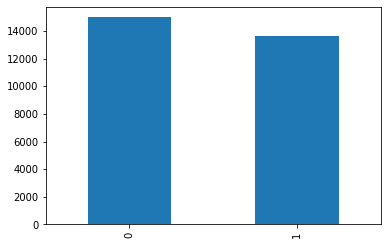

In [13]:
bar = df['is_sarcastic'].value_counts()
print(bar)
bar.plot(kind="bar")

### Cleaning the Texts

In [16]:
nlp = spacy.load("en_core_web_sm")

def clean_data(df, column):

  def lem_stp():

    for doc in nlp.pipe(df[column], disable=["parser", "ner"], batch_size=512):
        yield " ".join(
            [d.lemma_ for d in doc if not d.is_stop]
        )
  
  def clean(text):

    text = str(text).strip()

    if text:
      
      #Normalize Text
      text = normalize("NFKD", text)

      #Remove links 
      text = re.sub(r'https?:\/\/.*?[\s+]', '', text.replace("|"," ") + " ")

      #Strip Punctation
      text = re.sub(r'[^\w\s]','', text)

    return text.strip()

  df[column] = df[column].apply(clean)
  df[column] = list(lem_stp())
  df[column] = df[column].apply(lambda x: re.sub("\s+", " ", x.strip()))
  df[column] = df[column].apply(lambda x: x if len(x.split()) >= 5 else None)

  return df[column]

In [17]:
df["Cleaned"] = clean_data(df, "headline")
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [18]:
X = df["Cleaned"]
y = df["is_sarcastic"]

### Calculating Sequence Length

In [23]:
length = [len(x.split()) for x in X]

In [25]:
px.box(length)

### Tokenization

In [27]:
checkpoint = "bert-base-uncased"
# checkpoint = "gpt2"
sequence_length = 512

def tokenize(samples):

  tokenizer = AutoTokenizer.from_pretrained(checkpoint)

  if checkpoint == "gpt2" and tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

  tokens = tokenizer(
      samples,
      max_length=sequence_length,
      truncation=True,
      padding="max_length",
      add_special_tokens=True,
      return_tensors="np"
  )

  return {"input_ids": tokens["input_ids"].tolist(), "attention_mask": tokens["attention_mask"].tolist()}

In [29]:
X_tokenized = pd.DataFrame(tokenize(X.tolist()), columns=["input_ids", "attention_mask"])

In [30]:
X_tokenized

,input_ids,attention_mask
0,"[101, 4228, 14045, 20744, 7155, 4895, 3726, 40...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[101, 17183, 16360, 6135, 13774, 3519, 2991, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
2,"[101, 4521, 2310, 13871, 2666, 1023, 12090, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ..."
3,"[101, 4297, 16930, 4765, 4633, 4652, 16374, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
4,"[101, 2388, 2272, 3492, 2485, 2773, 11058, 111...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
...,...,...
24350,"[101, 3907, 10687, 2543, 2224, 2773, 14955, 86...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
24351,"[101, 2624, 4980, 2015, 7444, 3639, 4762, 2516...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
24352,"[101, 4722, 3821, 14064, 4487, 3736, 9397, 257...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
24353,"[101, 3376, 9920, 4613, 2733, 2272, 19483, 475...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."


In [34]:
X_tokenized.loc[0]

input_ids         [101, 4228, 14045, 20744, 7155, 4895, 3726, 40...
attention_mask    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 0, dtype: object

In [35]:
y

0        1
1        0
2        0
3        1
4        1
        ..
24350    1
24351    0
24352    1
24353    0
24354    1
Name: is_sarcastic, Length: 24355, dtype: int64

### Splitting Data into Train/Test

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_tokenized, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [37]:
X_train

,input_ids,attention_mask
5852,"[101, 10563, 2175, 2854, 2569, 3466, 2678, 670...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
24030,"[101, 12281, 12259, 2171, 6506, 4702, 6605, 35...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
10107,"[101, 2231, 2951, 22147, 2078, 3579, 13587, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
22361,"[101, 2342, 4157, 2058, 15637, 8040, 19058, 87...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
23631,"[101, 2158, 3294, 28279, 5178, 9428, 3671, 798...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
...,...,...
3059,"[101, 2047, 2259, 2335, 27830, 2565, 2202, 531...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
12109,"[101, 6221, 8398, 3781, 2015, 29300, 2278, 461...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
18350,"[101, 11503, 11733, 9298, 15350, 2015, 3104, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
11490,"[101, 15752, 2633, 3942, 7394, 3959, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [38]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19484, 2), (19484,), (4871, 2), (4871,))

### Unzipping the IDs and Masks

In [40]:
X_train["input_ids"][0]

[101,
 4228,
 14045,
 20744,
 7155,
 4895,
 3726,
 4014,
 12677,
 16150,
 4710,
 5119,
 2606,
 3279,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 

In [41]:
unzip_x = lambda x: [np.vstack(x["input_ids"]), np.vstack(x["attention_mask"])]

X_train, X_test = unzip_x(X_train), unzip_x(X_test)

In [44]:
X_train

[array([[  101, 10563,  2175, ...,     0,     0,     0],
        [  101, 12281, 12259, ...,     0,     0,     0],
        [  101,  2231,  2951, ...,     0,     0,     0],
        ...,
        [  101, 11503, 11733, ...,     0,     0,     0],
        [  101, 15752,  2633, ...,     0,     0,     0],
        [  101,  2334,  6338, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])]

### Building the model

In [47]:
def build_model(df, targets, checkpoint, sequence_length):

  base_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

  input_ids = Input(shape=(sequence_length,), name="input_ids", dtype="int32")
  attenion_mask = Input(shape=(sequence_length,), name="attention_mask", dtype="int32")

  if checkpoint == "gpt2": x = base_model.transformer(input_ids, attention_mask=attenion_mask)[0]
  else: x = base_model.bert(input_ids, attention_mask=attenion_mask)[1]

  x = Flatten()(x)

  units = df[targets].nunique()

  if units > 2:
      activation = "softmax"
      loss = "sparse_categorical_crossentropy"
  else:
      activation = "sigmoid"
      loss = "binary_crossentropy"
      units = units - 1

  outputs = Dense(units, activation = activation, name = f"{targets}_outputs")(x)

  model = Model(inputs=[input_ids, attenion_mask], outputs=outputs)

  optimizer =  tf.keras.optimizers.Adam()

  model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

  # Model Architecture Export
  tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, 
                          show_dtype=True, show_layer_names=True, rankdir='TB',
                          expand_nested=True, dpi=300, layer_range=None, 
                          show_layer_activations=True)

  return model

In [48]:
model = build_model(df, "is_sarcastic", checkpoint, sequence_length)

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

### Callbacks

In [54]:
def callbacks() -> list:

  def scheduler(epoch, lr):
    if epoch < 5:
      return lr
    else:
      return lr * tf.math.exp(-0.1)

    run_name = "run 1"
    save_path = Path("models")
    os.makedirs(save_path/"logs", exist_ok=True)
    
    checkpoint = ModelCheckpoint(save_path, monitor="val_loss", save_best_only=True, 
                                                    verbose=1)

    earlystopping = EarlyStopping(monitor="val_loss", verbose=1, restore_best_weights = True,
                                                    patience=5)

    logger = TensorBoard(save_path/"logs"/run_name, histogram_freq=2, write_graph=True, write_images=True)

    # lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, verbose=1,
    #                                      min_delta=0.0001, cooldown=0, min_lr=0)
    
    lr_schedule = LearningRateScheduler(scheduler, verbose = 1)
    
    return [checkpoint, earlystopping, lr_schedule, logger]

### Model Training

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=8, callbacks=callbacks())